# 20NG (Twenty Newsgroups). GenSim vs TopicNet

In this notebook we are going to train two topic models: one using TopicNet, and another one — using [GenSim](https://radimrehurek.com/gensim/).
So, we will be able to compare quality of the models, as well as the simplicity of each model's training process.

# Contents<a id="contents"></a>

* [Training a baseline TopicNet model](#topicnet-baseline)
* [GenSim LDA](#gensim-baseline)
* [Comparison](#comparison)

In [1]:
import numpy as np
import os
import pandas as pd
import requests
import shutil

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import cm

In [2]:
import topicnet as tn

from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.cooking_machine.recipes import ARTM_baseline
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

In [ ]:
make_notebook_pretty()

## Training a baseline TopicNet model<a id="topicnet-baseline"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Let's say we have a dataset as a .csv file with certain columns that requires TopicNet
(see for an example this [simple dataset](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/tests/test_data/test_dataset.csv) or docstring for `Dataset` class [here](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/cooking_machine/dataset.py)).

In [3]:
train_pd = pd.read_csv('20_News_dataset/train_preprocessed.csv', index_col=0)

In [4]:
train_pd['lemmatized'].head()

0    ['wonder', 'anyone', 'could', 'enlighten', 'ca...
1    ['fair', 'number', 'brave', 'soul', 'upgrade',...
2    ['well', 'folk', 'mac', 'plus', 'finally', 'gi...
3    ['weitek', 'address', 'phone', 'number', 'like...
4    ['article', 'tom', 'baker', 'understanding', '...
Name: lemmatized, dtype: object

The recipe for training is a carcass: we need to format it with real values in order to build experiment.
Let's do it and look at the result.

In [6]:
DATASET_PATH = '20_News_dataset/train_preprocessed.csv'
specific_topics = [f'topic_{i}' for i in range(20)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = ARTM_baseline.format(
    modality_list=['@lemmatized',],
    main_modality='@lemmatized',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string.replace('verbose: false', 'verbose: True'))


# This config follows a strategy described by Murat Apishev
# one of the core programmers of BigARTM library in personal correspondence.
# According to his letter 'decent' topic model can be obtained by
# Decorrelating model topics simultaneously looking at retrieved TopTokens


# Use .format(modality_list=modality_list, main_modality=main_modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, better left to the user to define optimal topic number
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19'] 
    background_topics: ['bcg_20']

# Here is example of model with one modality
regularizers:
    - DecorrelatorPhiRegularizer:
        name: 

Below we define a folder for the experiment, where topic models will be saved.
And build the experiment itself using the recipe.

In [7]:
EXPERIMENT_PATH = '/home/bulatov/Topicnet_20_news/'

if not os.path.exists(EXPERIMENT_PATH):
    os.mkdir(EXPERIMENT_PATH)
else:
    ! rm -rf $EXPERIMENT_PATH
    os.mkdir(EXPERIMENT_PATH)

experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id='baseline_coherence',
    save_path=EXPERIMENT_PATH,
)

Running the experiment!
Here happens all the model training stuff.
When the process is finished, `final_model` will be equal to one of the models from the last stage (`cube`) of the experiment.

In [8]:
final_model = list(experiment.run(dataset))[0]

/home/bulatov/anaconda3/lib/python3.7/site-packages/topicnet/cooking_machine/cubes/base_cube.py:225: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)


All models from all stages are also available

In [9]:
len(experiment.models)

14

One may use TopicNet's [viewers](https://github.com/machine-intelligence-laboratory/TopicNet/tree/master/topicnet/viewers) to observe a model a bit more thoroughly:

In [10]:
ttv = TopTokensViewer(final_model, method='blei', num_top_tokens=10)
output = ttv.view()

Now we will measure the coherence using the Palmetto webapp: http://palmetto.aksw.org/palmetto-webapp/ [1]

Please note that web API is not suitable for large-scale topic evaluations (it's better to run Palmetto locally: https://github.com/dice-group/Palmetto/wiki/How-Palmetto-can-be-used). But it should be OK to use web service for this small experiment.

[1] Röder M., Both A., Hinneburg A. Exploring the space of topic coherence measures. ACM, 2015.

In [11]:
S = "http://palmetto.aksw.org/palmetto-webapp/service/{}?words=".format("umass")

topic_score = []

for key, modalities in output.items():
    if 'topic' in key:
        words = list(output[key]['@lemmatized'].keys())
        print(" ".join(words))
        
        result = requests.get(S + "%20".join(words)).text
        print(result)
        
        topic_score += [float(result)]

card driver mac memory monitor video machine port mode apple
-2.6620788426087274
health disease drug medical patient doctor food study pain homosexual
-2.36002388521592
file program window use version include available system ftp application
-2.2203706523625897
kill fire woman child saw dead home azerbaijani dog burn
-2.9690412591920796
car bike engine water mile auto tire road insurance ride
-2.554291100068609
key chip encryption phone clipper internet privacy message security algorithm
-3.0340327896086667
state law gun government right weapon crime bill firearm court
-2.3915816085665687
post evidence theory exist atheist science argument question value atheism
-2.786434491778808
one would get go say think make people time know
-0.9119154367330198
power wire ground circuit light hot load battery appear heat
-2.3848900805753104
israel israeli jew arab war jewish palestinian peace land islam
-1.9388383305519246
software ibm fax motif sun image hp support tool printer
-2.949670069506974


## GenSim LDA<a id="gensim-baseline"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Preparing data for GenSim:

In [13]:
pd_data = pd.read_csv('20_News_dataset/train_preprocessed.csv', usecols=['lemmatized'])
data_texts = [string.split("'")[1::2] for string in pd_data['lemmatized'].values]

In [27]:
data_dictionary = Dictionary(data_texts)
data_corpus = [data_dictionary.doc2bow(text) for text in data_texts]

# force data_dictionary to initialize
data_dictionary[0]

In [33]:
id2word = data_dictionary.id2token

assert len(id2word) > 0

Setting training parameters for GenSim LDA model

In [35]:
num_topics = 20
passes = 10
iterations = 20
eval_every = 10  # Don't evaluate model perplexity, takes too much time.

alphas = ['auto', ] # or ['asymmetric', 'symmetric', 'auto', ]
model_list = []

for alpha in alphas:
    print(alpha)
    
    model_list += [LdaModel(
        corpus=data_corpus,
        id2word=id2word,
        alpha=alpha,
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )]

auto


Model quality estimation:

In [36]:
S = "http://palmetto.aksw.org/palmetto-webapp/service/{}?words=".format("umass")

m = model_list[-1]  # auto
topic_score_lda = []

for i in range(20):
    words = [data_dictionary[key] for key, _ in m.get_topic_terms(i)]
    print(" ".join(words))
    
    result = requests.get(S + "%20".join(words)).text
    print(result)
    
    topic_score_lda += [float(result)]

game team play player win year season hockey league score
-1.4119514978725671
card driver detector video ati slot diamond vram radar pem
-8.091411756426504
gun year weapon firearm crime run good would use control
-1.8536569158562008
space launch nasa satellite earth orbit mission moon shuttle data
-2.3207039160834184
israel israeli arab jew palestinian jewish attack land peace war
-1.4661764961326806
mail information list send include available post ftp email address
-2.782757379362371
wire ground use power circuit input water current cable connect
-2.2055467045061903
mm ut de mp sb bj ic ww mg idle
-6.244566738134345
file window program entry use widget set application motif server
-2.9926774252791626
president mr year state health tax program report work use
-1.400130093939828
food eat msg plane taste diet chinese reaction brain restaurant
-3.02833932507377
god jesus christian believe say bible religion church one people
-1.2705218288828104
use drive system disk image software run wi

## Comparison<a id="comparison"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Let's visualize the results.

Just below is a quick and dirty way to get an overview of coherence distributions.

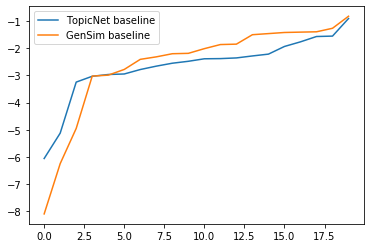

In [38]:
plt.plot(sorted(topic_score), label="TopicNet baseline")
plt.plot(sorted(topic_score_lda), label="GenSim baseline")

plt.legend()
plt.show()

In [39]:
ts = np.array(topic_score)

print(ts.mean(), ts.std())

-2.663104672728601 1.1326448987351097


In [40]:
ts_lda = np.array(topic_score_lda)

print(ts_lda.mean(), ts_lda.std())

-2.613513536576834 1.7721566495261374


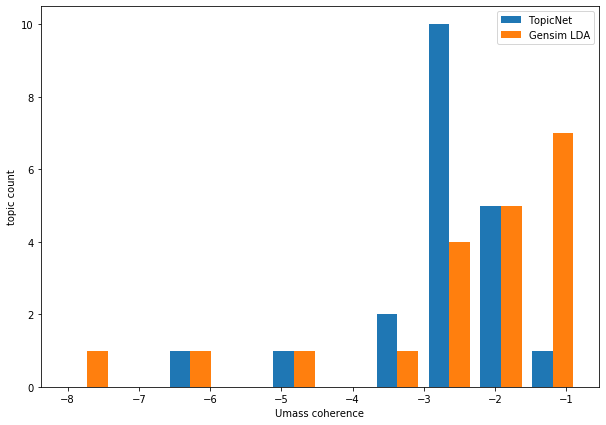

In [43]:
plt.figure(figsize=(10,7))

plt.hist(
    (ts, ts_lda), histtype='bar', stacked=False, label=['TopicNet','Gensim LDA']
)
plt.xlabel('Umass coherence')
plt.ylabel('topic count')
plt.legend(prop={'size': 10})

plt.show()

In [48]:
lda_toptokens = []

m = model_list[-1]  # auto

for i in range(20):
    words = [data_dictionary[key] for key, _ in m.get_topic_terms(i)]
    lda_toptokens += [words]

In [47]:
topicnet_toptokens = []

output = ttv.view()

for key, modalities in output.items():
    if 'topic' in key:
        words = list(output[key]['@lemmatized'].keys())
        topicnet_toptokens += [words]

In [ ]:
def calc_jaccard_distance(fst_set, snd_set):
    """
    :param fst_set: set of objects
    :param snd_set: set of objects
    :return: jaccard distance (https://en.wikipedia.org/wiki/Jaccard_index)
    of the provided two sets
    """
    if fst_set or snd_set:
        return 1. * len(fst_set & snd_set) / (len(fst_set | snd_set))
    else:
        return 0.

def calc_avg_pairwise_jaccards(sets):
    """
    :param sets: list of sets
    :return: average jaccard distance between these sets
    """
    size = len(sets)
    res = 0.
    num_zeros = 0.

    for i in range(size):
        for j in range(size):
            if i != j:
                dist = calc_jaccard_distance(set(sets[i]), set(sets[j]))
                
                if dist == 0:
                    num_zeros += 1
                
                res += dist

    total = size * (size - 1)
    
    print("number of non-intersecting topics: ", num_zeros / total)
    
    return res / size / (size - 1)

In [50]:
print("topicnet top tokens", calc_avg_pairwise_jaccards(topicnet_toptokens))
print('*****')
print("lda toptokens", calc_avg_pairwise_jaccards(lda_toptokens))

number of non-intersecting topics:  1.0
topicnet top tokens 0.0
*****
number of non-intersecting topics:  0.8105263157894737
lda toptokens 0.01608051346115546
